# Boids: Simulating a Flock
## Aleesia, Eniola, Ghislain
### Our objective is to simulate the coordinated motion and natural behaviour of bird flocks and fish schools in nature and demonstrate our simulation with matplotlib.

#### Here we start by importing relevant libraries such as matplotlib which helps animate our plot as well as other necessary libraries such as numpy for faster computation with arrays and easy acces to math operations.

In [2]:
%matplotlib ipympl
import sys, argparse
import math
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from scipy.spatial.distance import squareform, pdist, cdist
from numpy.linalg import norm

#### Now starting with our simulation,

starting boids...


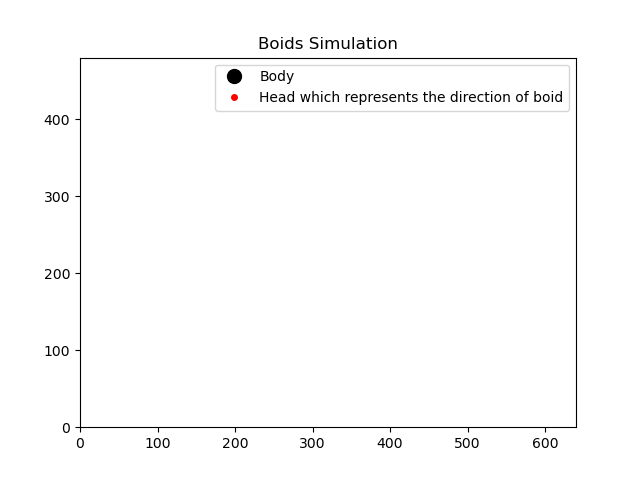

NameError: name 'a' is not defined

In [25]:
width, height = 640, 480 # set size of box of simulation which is adjustable

class Boids: 
    """Class that represents Boids simulation"""
    
    def __init__(self, N): # initializes the position and velocity as well as sets the minimum distance bettween each boid.
        """ initialize the Boid simulation""" 
        # init position & velocities
        self.pos = [width/2.0, height/2.0] + 10*np.random.rand(2*N).reshape(N, 2)
        # normalized random velocities
        angles = 2*math.pi*np.random.rand(N)
        self.vel = np.array(list(zip(np.sin(angles), np.cos(angles))))
        self.N = N
        # min dist of approach
        self.minDist = 25.0
        # max magnitude of velocities calculated by "rules"
        self.maxRuleVel = 0.03
        # max maginitude of final velocity
        self.maxVel = 2.0
        
        
    def tick(self, frameNum, pts, beak): # sets framerate the rate (frames per second) at which each frame of the simulation appears.
        """Update the simulation by one time step."""
        # get pairwise distances
        self.distMatrix = squareform(pdist(self.pos))
        # apply rules:
        self.vel += self.applyRules()
        self.limit(self.vel, self.maxVel)
        self.pos += self.vel
        self.applyBC()
        # update data
        pts.set_data(self.pos.reshape(2*self.N)[::2], self.pos.reshape(2*self.N)[1::2])
        vec = self.pos + 10*self.vel/self.maxVel
        beak.set_data(vec.reshape(2*self.N)[::2], vec.reshape(2*self.N)[1::2])

   
    def limitVec(self, vec, maxVal): # threshold value for the velocity of each boid, needed to ensure the velocity will 
        # not increase indefinitely and have the simulation crash.
        """limit magnitide of 2D vector"""
        mag = norm(vec)
        if mag > maxVal:
            vec[0], vec[1] = vec[0]*maxVal/mag, vec[1]*maxVal/mag
    def limit(self, X, maxVal):
        """limit magnitide of 2D vectors in array X to maxValue"""
        for vec in X:
            self.limitVec(vec, maxVal)
            
    
    def applyBC(self): # ensures that if a boid goes out of frame it re-appears on the opposite side.
        """apply boundary conditions"""
        deltaR = 2.0
        for coord in self.pos:
            if coord[0] > width + deltaR:
                coord[0] = - deltaR
            if coord[0] < - deltaR:
                coord[0] = width + deltaR    
            if coord[1] > height + deltaR:
                coord[1] = - deltaR
            if coord[1] < - deltaR:
                coord[1] = height + deltaR
     
   
    
    #APPLY FUNDAMNETAL RULES
    
    def applyRules(self):
        
        #Rule 1 - Separation: 
        D = self.distMatrix < 25.0 # minimun distance that a boid has to maintain with other boids
        vel = self.pos*D.sum(axis=1).reshape(self.N, 1) - D.dot(self.pos) #maintains specific velocity
        self.limit(vel, self.maxRuleVel)

        
        
        #RULE 2 - Alignment
        D = self.distMatrix < 50.0 # sets different distance threshold for Alignment rule
        vel2 = D.dot(self.vel)  # apply Alignment
       # when you apply the alignmet rule the velocity  of all local boids of a radius of 50 units set as d above this is done
        # so the computed final velocity doesnt increase indefinetly 
        # this is done so that any given boid aligns itself wiht the average velocity of the boids within their specified radius
        self.limit(vel2, self.maxRuleVel)
        vel += vel2 #updates the velocity
        
        
        
        #RULE 3 - Cohesion
        # apply rule #3 - Cohesion
        vel3 = D.dot(self.pos) - self.pos # assigns a velocity vector that tends our boid towards the geometric center. Where D.dot(self.pos) 
        # is the geomtetric center and self.pos is the position of our boid.
        self.limit(vel3, self.maxRuleVel)
        vel += vel3 #updates velocity
        
        return vel


    
    
    def buttonPress(self, event): # allows for us to add a boid to our flock or scatter our boids
        """event handler for matplotlib button presses"""
        # left click - add a boid
        if event.button == 1:
            self.pos = np.concatenate((self.pos, np.array([[event.xdata, event.ydata]])), axis=0)
            angles = 2*math.pi*np.random.rand(1)
            v = np.array(list(zip(np.sin(angles), np.cos(angles))))
            self.vel = np.concatenate((self.vel, v), axis=0)
            self.N += 1 
        # right click - scatter our boids by adding a scattering velocity that pushes our boids away from the point we click on, representing a reaction to some predator given a flock of prey.
        elif event.button == 3:
            
            self.vel += 0.1*(self.pos - np.array([[event.xdata, event.ydata]]))
            
def tick(frameNum, pts, beak, boids): 
        """update function for animation"""
        boids.tick(frameNum, pts, beak)
        return pts, beak


def main(): # executes boids class above when called
    
    print('starting boids...')

    parser = argparse.ArgumentParser(description="Implementing Craig Reynold's Boids...") # for user friendly command line interfaces 
    parser.add_argument('--num-boids', dest='N', required=False)
    args, unknown = parser.parse_known_args()
   

    # Assigns number of boids and generates them using our Boid class
    N = 100
    if args.N:
        N = int(args.N)
    boids = Boids(N)

    # this step is for setting up our plot and assigning a shape, size and color to our boids' body and heading. 
    fig = plt.figure()
    ax = plt.axes(xlim=(0, width), ylim=(0, height))
    ax.set_title('Boids Simulation')
    pts, = ax.plot([], [], markersize=10, 
                  c='k', marker='o', ls='None', label = 'Body')
    beak, = ax.plot([], [], markersize=4, 
                  c='r', marker='o', ls='None', label = 'Head which represents the direction of boid')
    anim = animation.FuncAnimation(fig, tick, fargs=(pts, beak, boids),
                                 interval=50)
    plt.legend()
    plt.show()
   
    # adds our button press to our plot, our ability to add one boid per left click or scatter our boids at every right click.
    cid = fig.canvas.mpl_connect('button_press_event', boids.buttonPress)
    return a


if __name__ == '__main__': 
    main() # call main

#### For experiment let's see how our boids interact with the Separation rule disabled,

starting boids...


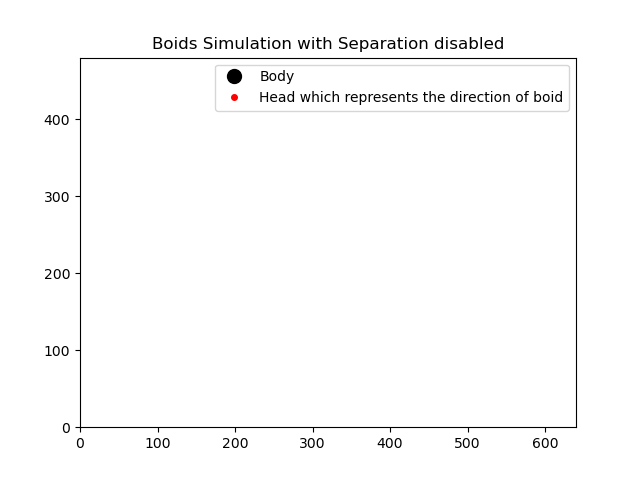

NameError: name 'a' is not defined

In [26]:
width, height = 640, 480

class Boids:
    """Class that represents Boids simulation"""
    def __init__(self, N):
        """ initialize the Boid simulation"""
        # init position & velocities
        self.pos = [width/2.0, height/2.0] + 10*np.random.rand(2*N).reshape(N, 2)
        # normalized random velocities
        angles = 2*math.pi*np.random.rand(N)
        self.vel = np.array(list(zip(np.sin(angles), np.cos(angles))))
        self.N = N
        # min dist of approach
        self.minDist = 25.0
        # max magnitude of velocities calculated by "rules"
        self.maxRuleVel = 0.03
        # max maginitude of final velocity
        self.maxVel = 2.0
        
    def tick(self, frameNum, pts, beak):
        """Update the simulation by one time step."""
        # get pairwise distances
        self.distMatrix = squareform(pdist(self.pos))
        # apply rules:
        self.vel += self.applyRules()
        self.limit(self.vel, self.maxVel)
        self.pos += self.vel
        self.applyBC()
        # update data
        pts.set_data(self.pos.reshape(2*self.N)[::2], self.pos.reshape(2*self.N)[1::2])
        vec = self.pos + 10*self.vel/self.maxVel
        beak.set_data(vec.reshape(2*self.N)[::2], vec.reshape(2*self.N)[1::2])

    def limitVec(self, vec, maxVal):
        """limit magnitide of 2D vector"""
        mag = norm(vec)
        if mag > maxVal:
            vec[0], vec[1] = vec[0]*maxVal/mag, vec[1]*maxVal/mag
            
    def limit(self, X, maxVal):
        """limit magnitide of 2D vectors in array X to maxValue"""
        for vec in X:
            self.limitVec(vec, maxVal)
            
    def applyBC(self):
        """apply boundary conditions"""
        deltaR = 2.0
        for coord in self.pos:
            if coord[0] > width + deltaR:
                coord[0] = - deltaR
            if coord[0] < - deltaR:
                coord[0] = width + deltaR    
            if coord[1] > height + deltaR:
                coord[1] = - deltaR
            if coord[1] < - deltaR:
                coord[1] = height + deltaR
                
    def applyRules(self):
        # apply rule #1 - Separation
        D = self.distMatrix < 25.0
        vel = self.pos*D.sum(axis=1).reshape(self.N, 1) - D.dot(self.pos)
        # This disables the separation self.limit(vel, self.maxRuleVel)

        # different distance threshold
        D = self.distMatrix < 50.0

        # apply rule #2 - Alignment
        vel2 = D.dot(self.vel)
        self.limit(vel2, self.maxRuleVel)
        vel += vel2 

        # apply rule #1 - Cohesion
        vel3 = D.dot(self.pos) - self.pos
        self.limit(vel3, self.maxRuleVel)
        vel += vel3

        return vel

    def buttonPress(self, event):
        """event handler for matplotlib button presses"""
        # left click - add a boid
        if event.button == 1:
            self.pos = np.concatenate((self.pos, np.array([[event.xdata, event.ydata]])), axis=0)
            # random velocity
            angles = 2*math.pi*np.random.rand(1)
            v = np.array(list(zip(np.sin(angles), np.cos(angles))))
            self.vel = np.concatenate((self.vel, v), axis=0)
            self.N += 1 
        # right click - scatter
        elif event.button == 3:
            # add scattering velocity 
            self.vel += 0.1*(self.pos - np.array([[event.xdata, event.ydata]]))
            
            
def tick(frameNum, pts, beak, boids):
    #print frameNum 
    """update function for animation"""
    boids.tick(frameNum, pts, beak)
    return pts, beak

# main() function
def main():
    # use sys.argv if needed
    print('starting boids...')

    parser = argparse.ArgumentParser(description="Implementing Craig Reynold's Boids...")
      # add arguments
    parser.add_argument('--num-boids', dest='N', required=False)
      #args = parser.parse_args()
    args, unknown = parser.parse_known_args()
      # number of boids
    N = 100
    if args.N:
        N = int(args.N)

    # create boids
    boids = Boids(N)

    # setup plot
    fig = plt.figure()
    ax = plt.axes(xlim=(0, width), ylim=(0, height))
    ax.set_title('Boids Simulation with Separation disabled')
    pts, = ax.plot([], [], markersize=10, 
                  c='k', marker='o', ls='None', label = 'Body')
    beak, = ax.plot([], [], markersize=4, 
                  c='r', marker='o', ls='None', label = 'Head which represents the direction of boid')
    anim = animation.FuncAnimation(fig, tick, fargs=(pts, beak, boids),
                                 interval=50)
    plt.legend()
    plt.show()
   
    # add a "button press" event handler
    cid = fig.canvas.mpl_connect('button_press_event', boids.buttonPress)
    return a

 #call main
if __name__ == '__main__':
    main()

#### We see the boids no longer mainatin a minimum distance thus there are points in our simulation where our boids touch each other some where they're very spaced out thus losing the uniformity found in flock group behaviour.

#### Now with Aligment disabled,

starting boids...


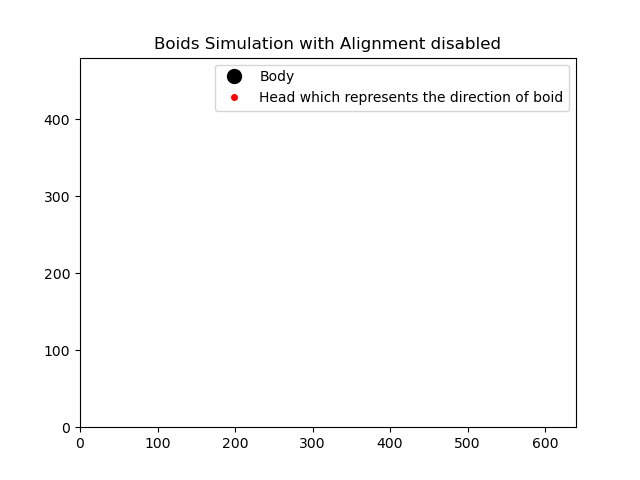

NameError: name 'a' is not defined

In [27]:
width, height = 640, 480

class Boids:
    """Class that represents Boids simulation"""
    def __init__(self, N):
        """ initialize the Boid simulation"""
        # init position & velocities
        self.pos = [width/2.0, height/2.0] + 10*np.random.rand(2*N).reshape(N, 2)
        # normalized random velocities
        angles = 2*math.pi*np.random.rand(N)
        self.vel = np.array(list(zip(np.sin(angles), np.cos(angles))))
        self.N = N
        # min dist of approach
        self.minDist = 25.0
        # max magnitude of velocities calculated by "rules"
        self.maxRuleVel = 0.03
        # max maginitude of final velocity
        self.maxVel = 2.0
        
    def tick(self, frameNum, pts, beak):
        """Update the simulation by one time step."""
        # get pairwise distances
        self.distMatrix = squareform(pdist(self.pos))
        # apply rules:
        self.vel += self.applyRules()
        self.limit(self.vel, self.maxVel)
        self.pos += self.vel
        self.applyBC()
        # update data
        pts.set_data(self.pos.reshape(2*self.N)[::2], self.pos.reshape(2*self.N)[1::2])
        vec = self.pos + 10*self.vel/self.maxVel
        beak.set_data(vec.reshape(2*self.N)[::2], vec.reshape(2*self.N)[1::2])

    def limitVec(self, vec, maxVal):
        """limit magnitide of 2D vector"""
        mag = norm(vec)
        if mag > maxVal:
            vec[0], vec[1] = vec[0]*maxVal/mag, vec[1]*maxVal/mag
            
    def limit(self, X, maxVal):
        """limit magnitide of 2D vectors in array X to maxValue"""
        for vec in X:
            self.limitVec(vec, maxVal)
            
    def applyBC(self):
        """apply boundary conditions"""
        deltaR = 2.0
        for coord in self.pos:
            if coord[0] > width + deltaR:
                coord[0] = - deltaR
            if coord[0] < - deltaR:
                coord[0] = width + deltaR    
            if coord[1] > height + deltaR:
                coord[1] = - deltaR
            if coord[1] < - deltaR:
                coord[1] = height + deltaR
                
    def applyRules(self):
        # apply rule #1 - Separation
        D = self.distMatrix < 25.0
        vel = self.pos*D.sum(axis=1).reshape(self.N, 1) - D.dot(self.pos)
        self.limit(vel, self.maxRuleVel)

        # different distance threshold
        D = self.distMatrix < 50.0

        # apply rule #2 - Alignment
        #vel2 = D.dot(self.vel)
        #self.limit(vel2, self.maxRuleVel)
        #vel += vel2 
        #disabled Alignment steer

        # apply rule #1 - Cohesion
        vel3 = D.dot(self.pos) - self.pos
        self.limit(vel3, self.maxRuleVel)
        vel += vel3

        return vel
    
    #def avoidObstacle(self):
       # tuple = (x,y,R) #Predefined tuple
       # self.vel += self.applyRules()
       # self.vel += self.avoidObstacle()

    def buttonPress(self, event):
        """event handler for matplotlib button presses"""
        # left click - add a boid
        if event.button == 1:
            self.pos = np.concatenate((self.pos, np.array([[event.xdata, event.ydata]])), axis=0)
            # random velocity
            angles = 2*math.pi*np.random.rand(1)
            v = np.array(list(zip(np.sin(angles), np.cos(angles))))
            self.vel = np.concatenate((self.vel, v), axis=0)
            self.N += 1 
        # right click - scatter
        elif event.button == 3:
            # add scattering velocity 
            self.vel += 0.1*(self.pos - np.array([[event.xdata, event.ydata]]))
            
            
def tick(frameNum, pts, beak, boids):
    #print frameNum 
    """update function for animation"""
    boids.tick(frameNum, pts, beak)
    return pts, beak

# main() function
def main():
    # use sys.argv if needed
    print('starting boids...')

    parser = argparse.ArgumentParser(description="Implementing Craig Reynold's Boids...")
      # add arguments
    parser.add_argument('--num-boids', dest='N', required=False)
      #args = parser.parse_args()
    args, unknown = parser.parse_known_args()
      # number of boids
    N = 100
    if args.N:
        N = int(args.N)

    # create boids
    boids = Boids(N)

    # setup plot
    fig = plt.figure()
    ax = plt.axes(xlim=(0, width), ylim=(0, height))
    ax.set_title('Boids Simulation with Alignment disabled')
    pts, = ax.plot([], [], markersize=10, 
                  c='k', marker='o', ls='None', label = 'Body')
    beak, = ax.plot([], [], markersize=4, 
                  c='r', marker='o', ls='None', label = 'Head which represents the direction of boid')
    anim = animation.FuncAnimation(fig, tick, fargs=(pts, beak, boids),
                                 interval=50)
    plt.legend()
    plt.show()
   
    # add a "button press" event handler
    cid = fig.canvas.mpl_connect('button_press_event', boids.buttonPress)
    return a

 #call main
if __name__ == '__main__':
    main()

#### Although there are no colisions there are many stray boids in the simulation as there's no shared sense of direction, and with the visibilty shpere disabled there is a general lack of harmony in the final simulation.

#### With Cohesion disabled,

In [7]:
width, height = 640, 480

class Boids:
    """Class that represents Boids simulation"""
    def __init__(self, N):
        """ initialize the Boid simulation"""
        # init position & velocities
        self.pos = [width/2.0, height/2.0] + 10*np.random.rand(2*N).reshape(N, 2)
        # normalized random velocities
        angles = 2*math.pi*np.random.rand(N)
        self.vel = np.array(list(zip(np.sin(angles), np.cos(angles))))
        self.N = N
        # min dist of approach
        self.minDist = 25.0
        # max magnitude of velocities calculated by "rules"
        self.maxRuleVel = 0.03
        # max maginitude of final velocity
        self.maxVel = 2.0
        
    def tick(self, frameNum, pts, beak):
        """Update the simulation by one time step."""
        # get pairwise distances
        self.distMatrix = squareform(pdist(self.pos))
        # apply rules:
        self.vel += self.applyRules()
        self.limit(self.vel, self.maxVel)
        self.pos += self.vel
        self.applyBC()
        # update data
        pts.set_data(self.pos.reshape(2*self.N)[::2], self.pos.reshape(2*self.N)[1::2])
        vec = self.pos + 10*self.vel/self.maxVel
        beak.set_data(vec.reshape(2*self.N)[::2], vec.reshape(2*self.N)[1::2])

    def limitVec(self, vec, maxVal):
        """limit magnitide of 2D vector"""
        mag = norm(vec)
        if mag > maxVal:
            vec[0], vec[1] = vec[0]*maxVal/mag, vec[1]*maxVal/mag
            
    def limit(self, X, maxVal):
        """limit magnitide of 2D vectors in array X to maxValue"""
        for vec in X:
            self.limitVec(vec, maxVal)
            
    def applyBC(self):
        """apply boundary conditions"""
        deltaR = 2.0
        for coord in self.pos:
            if coord[0] > width + deltaR:
                coord[0] = - deltaR
            if coord[0] < - deltaR:
                coord[0] = width + deltaR    
            if coord[1] > height + deltaR:
                coord[1] = - deltaR
            if coord[1] < - deltaR:
                coord[1] = height + deltaR
                
    def applyRules(self):
        # apply rule #1 - Separation
        D = self.distMatrix < 25.0
        vel = self.pos*D.sum(axis=1).reshape(self.N, 1) - D.dot(self.pos)
        # This disables the separation self.limit(vel, self.maxRuleVel)

        # different distance threshold
        D = self.distMatrix < 50.0

        # apply rule #2 - Alignment
        vel2 = D.dot(self.vel)
        self.limit(vel2, self.maxRuleVel)
        vel += vel2 

        # apply rule #1 - Cohesion
        #vel3 = D.dot(self.pos) - self.pos
        #self.limit(vel3, self.maxRuleVel) #disbales cohesion
        #vel += vel3

        return vel
    
    #def avoidObstacle(self):
       # tuple = (x,y,R) #Predefined tuple
       # self.vel += self.applyRules()
       # self.vel += self.avoidObstacle()

    def buttonPress(self, event):
        """event handler for matplotlib button presses"""
        # left click - add a boid
        if event.button == 1:
            self.pos = np.concatenate((self.pos, np.array([[event.xdata, event.ydata]])), axis=0)
            # random velocity
            angles = 2*math.pi*np.random.rand(1)
            v = np.array(list(zip(np.sin(angles), np.cos(angles))))
            self.vel = np.concatenate((self.vel, v), axis=0)
            self.N += 1 
        # right click - scatter
        elif event.button == 3:
            # add scattering velocity 
            self.vel += 0.1*(self.pos - np.array([[event.xdata, event.ydata]]))
            
            
def tick(frameNum, pts, beak, boids):
    #print frameNum 
    """update function for animation"""
    boids.tick(frameNum, pts, beak)
    return pts, beak

# main() function
def main():
    # use sys.argv if needed
    print('starting boids...')

    parser = argparse.ArgumentParser(description="Implementing Craig Reynold's Boids...")
      # add arguments
    parser.add_argument('--num-boids', dest='N', required=False)
      #args = parser.parse_args()
    args, unknown = parser.parse_known_args()
      # number of boids
    N = 100
    if args.N:
        N = int(args.N)

    # create boids
    boids = Boids(N)

    # setup plot
    fig = plt.figure()
    ax = plt.axes(xlim=(0, width), ylim=(0, height))
    ax.set_title('Boids Simulation with Cohesion disabled')
    pts, = ax.plot([], [], markersize=10, 
                  c='k', marker='o', ls='None', label = 'Body')
    beak, = ax.plot([], [], markersize=4, 
                  c='r', marker='o', ls='None', label = 'Head which represents the direction of boid')
    anim = animation.FuncAnimation(fig, tick, fargs=(pts, beak, boids),
                                 interval=50)
    plt.legend()
    plt.show()
   
    # add a "button press" event handler
    cid = fig.canvas.mpl_connect('button_press_event', boids.buttonPress)
    return a

 #call main
if __name__ == '__main__':
    main()

IndentationError: expected an indented block (3962571438.py, line 143)

#### As there is no velocity pulling any boid near the avreage position of it's surrounding boids, they simply drift away from each other indefinetly which is clearly not a representation of flock group behaviour.

### To conclude, we've seen that with the help of Python, techniques learned in class and just 3 simple rules we can recreate the seemingly complex behaviour exhibited by flock groups. With this, we can gain a deeper understanding of the various forms of flocking behaviour found in our physical world and how this gives rise to many relevant and important applications in technology, scientific research and entertainment.